In [0]:
# define widgets - NEED TO DEFINE IT ONCE
# dynamic variables (pass it from ADF)
# first time runtime parameter
#dbutils.widgets.dropdown("environment", "dev", ["dev","uat","prod"])
#dbutils.widgets.dropdown("new_training", "False", ["True","False"])
#dbutils.widgets.dropdown("system_name", "bimodelapi", ["bimodelapi"])
# dbutils.widgets.text("system_name", "","")
# dbutils.widgets.remove("pbiapi")
environment = dbutils.widgets.get("environment")
new_training = dbutils.widgets.get("new_training")
system_name = dbutils.widgets.get("system_name")
if environment in {"prod"}:
    aml_compute_cluster_name = "cc-bi-ml-prod01"
else:
    aml_compute_cluster_name = "cc-bi-ml-devqa01"

print(environment, system_name, new_training, aml_compute_cluster_name)


dev bimodelapi True cc-bi-ml-devqa01

dev bimodelapi True cc-bi-ml-devqa01

EnvironmentName,ParameterName,ParameterValue,SystemName
dev,ws_resource_group,rg-bi-automl-devqa01,bimodelapi
dev,workspace_name,mlw-bi-automl-devqa01,bimodelapi
dev,workspace_region,westus,bimodelapi


0 : ^GSPC,1 : ^FTSE,2 : ^N100,3 : ^N225,4 : 000001.SS,<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 63 non-null datetime64[ns]
 1 EURONEXT_100 63 non-null float64 
 2 FTSE_100 63 non-null float64 
 3 Nikkei_225 63 non-null float64 
 4 SP_500 63 non-null float64 
 5 SSE_Composite_Index 63 non-null float64 
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.1 KB

End_of_Month,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index
2020-11-30T00:00:00.000+0000,1088.72998046875,6266.2001953125,26433.619140625,3621.6298828125,3391.760009765625
2020-12-31T00:00:00.000+0000,1103.5400390625,6460.5,27444.169921875,3756.070068359375,3473.069091796875
2021-01-31T00:00:00.000+0000,1085.3800048828125,6407.5,27663.390625,3714.239990234375,3483.069091796875
2021-02-28T00:00:00.000+0000,1123.0799560546875,6483.39990234375,28966.009765625,3811.14990234375,3509.080078125
2021-03-31T00:00:00.000+0000,1172.469970703125,6699.2001953125,28405.51953125,3910.52001953125,3411.510009765625


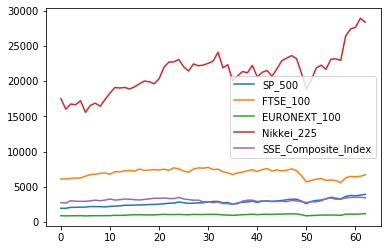

pipehist : (80096, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80096 entries, 0 to 80095
Data columns (total 9 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date_Short 80096 non-null datetime64[ns]
 1 Relative_Snapshot_Month_Offset 80096 non-null int64 
 2 End_of_Month 80096 non-null datetime64[ns]
 3 Relative_Month_Offset 80096 non-null int64 
 4 Sub_Region_Code 78853 non-null object 
 5 Pipeline_Type 80096 non-null object 
 6 Pipeline 80005 non-null object 
 7 Yield 61678 non-null float64 
 8 Yield_Amount 64423 non-null object 
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 5.5+ MB
/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field Sub_Region_Code. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion from Arrow: null
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline_Type,Pipeline,Yield,Yield_Amount
2020-10-11T00:00:00.000+0000,-5,2020-11-30T00:00:00.000+0000,-4,NaN,Opportunity,130789.38,NaN,NaN
2020-10-11T00:00:00.000+0000,-5,2020-12-31T00:00:00.000+0000,-3,NaN,Opportunity,143245.52,NaN,NaN
2020-10-18T00:00:00.000+0000,-5,2020-10-31T00:00:00.000+0000,-5,NaN,Opportunity,62280.66,NaN,NaN
2020-10-18T00:00:00.000+0000,-5,2020-11-30T00:00:00.000+0000,-4,NaN,Opportunity,130789.38,NaN,NaN
2020-10-18T00:00:00.000+0000,-5,2020-12-31T00:00:00.000+0000,-3,NaN,Opportunity,143245.52,NaN,NaN


talenthist : (2526, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 2526 non-null datetime64[ns]
 1 Sub_Region_Code 2430 non-null object 
 2 Journey_Level 2526 non-null object 
 3 Headcount 2150 non-null float64 
 4 Headcount_Contingent 892 non-null float64 
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 98.8+ KB

End_of_Month,Sub_Region_Code,Journey_Level,Headcount,Headcount_Contingent
2017-01-31T00:00:00.000+0000,Global,Team,19.0,null
2017-01-31T00:00:00.000+0000,Global,Director,11.5,null
2017-01-31T00:00:00.000+0000,Global,Enterprise,15.8,null
2017-01-31T00:00:00.000+0000,Global,Unknown,1.0,5.0
2017-01-31T00:00:00.000+0000,null,Unknown,null,5.0


revhist : (415, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 3 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 415 non-null datetime64[ns]
 1 Sub_Region_Code 414 non-null object 
 2 Revenue 415 non-null object 
dtypes: datetime64[ns](1), object(2)
memory usage: 9.9+ KB

End_of_Month,Sub_Region_Code,Revenue
2021-04-30T00:00:00.000+0000,Play Lab,250000.00
2021-05-31T00:00:00.000+0000,Academy,960645.00
2021-05-31T00:00:00.000+0000,Play Lab,125000.00
2021-06-30T00:00:00.000+0000,Academy,48000.00
2021-06-30T00:00:00.000+0000,Play Lab,50000.00


opphist : (593, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 7 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 593 non-null datetime64[ns]
 1 Sub_Region_Code 527 non-null object 
 2 Opportunity_Period_Count 256 non-null float64 
 3 Opportunity_Count 593 non-null int64 
 4 Current_Opp._Period_Value 242 non-null float64 
 5 Opportunity_Value 584 non-null float64 
 6 Win_Rate 189 non-null float64 
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 32.6+ KB

End_of_Month,Sub_Region_Code,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate
2023-12-31T00:00:00.000+0000,Academy,null,4,null,14925.0,null
2023-12-31T00:00:00.000+0000,Centers of Excellence,null,11,null,1300000.0,null
2023-12-31T00:00:00.000+0000,Play Lab,null,6,null,1094000.0,null
2023-12-31T00:00:00.000+0000,Global,null,2,null,233601.0,null
2023-12-31T00:00:00.000+0000,null,null,11,null,2267016.0,null


projhist : (639, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 639 non-null datetime64[ns]
 1 Sub_Region_Code 636 non-null object 
 2 Project_Period_Price 369 non-null float64 
 3 Project_Price 638 non-null float64 
 4 Conversions 320 non-null object 
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 25.1+ KB
/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field Conversions. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion from Arrow: null
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

End_of_Month,Sub_Region_Code,Project_Period_Price,Project_Price,Conversions
2023-12-31T00:00:00.000+0000,North America,NaN,1.17131827E8,NaN
2023-12-31T00:00:00.000+0000,Europe,NaN,1.538432393E7,NaN
2023-12-31T00:00:00.000+0000,Centers of Excellence,NaN,8438954.0,NaN
2023-12-31T00:00:00.000+0000,Play Lab,NaN,1388384.0,NaN
2023-12-31T00:00:00.000+0000,Global,NaN,8913323.0,NaN


pipetrend : (12823, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12823 entries, 0 to 12822
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date_Short 12823 non-null datetime64[ns]
 1 End_of_Month 12823 non-null datetime64[ns]
 2 Sub_Region_Code 12306 non-null object 
 3 Pipeline_Type 12823 non-null object 
 4 Pipeline_Trend 12823 non-null object 
dtypes: datetime64[ns](2), object(3)
memory usage: 501.0+ KB

Snapshot_Date_Short,End_of_Month,Sub_Region_Code,Pipeline_Type,Pipeline_Trend
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Play Lab,Active Unrecognized,354467.35
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Play Lab,Opportunity,46803.36
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Global,Active Unrecognized,342912.09
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Global,Opportunity ML,54484.25
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,null,Opportunity,256717.84


In [0]:
%run ./data_load_rev_region_forecast

In [0]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# Prepare Data

# set variales

target_column_name = 'Revenue'
time_column_name = 'End_of_Month'
time_series_id_column_names = ['Relative_Offset', 'Snp_Seq_No', 'Sub_Region_Code']
sort_cols_snp = ['End_of_Month', 'Snapshot_Date', 'Sub_Region_Code']
sort_cols_eom = ['End_of_Month', 'Sub_Region_Code']

exclude_sub_region = ['Singapore', 'NA']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

talenthist1 = talenthist.copy()  # .toPandas() to convert from spark df to pandas
pipehist1 = pipehist.copy()
opphist1 = opphist.copy()
projhist1 = projhist.copy()
revhist1 = revhist.copy()
pipetrend1 = pipetrend.copy()

# pipetrend1.drop(columns="Snapshot_Date_Short", axis=1, inplace=True)

pipehist1.rename(columns={'Snapshot_Date_Short': 'Snapshot_Date'},
                 inplace=True)
pipetrend1.rename(columns={'Snapshot_Date_Short': 'Snapshot_Date'},
                  inplace=True)
talenthist1['Billable_Headcount'] = talenthist1['Headcount'] \
    + talenthist1['Headcount_Contingent']
talenthist1.drop(columns=['Headcount', 'Headcount_Contingent'], axis=1,
                 inplace=True)

numeric_cols = [
    'Pipeline',
    'Revenue',
    'Yield_Amount',
    'Conversions',
    'Yield',
    'Pipeline_Trend',
    'Win_Rate',
    ]

for x in [
    pipehist1,
    talenthist1,
    revhist1,
    opphist1,
    projhist1,
    pipetrend1,
    ]:
    x.infer_objects()

    # convert date to to_datetime

    x = convert_date_cols(x)

    # coerce some fields to numeric

    for col in numeric_cols:
        if col in x.columns:
            x[col] = x[col].apply(pd.to_numeric, errors='coerce'
                                  ).replace(np.nan, 0, regex=True)

    # replace null values to NA

    x['Sub_Region_Code'] = x['Sub_Region_Code'].replace(np.nan, 'NA',
            regex=True)

    x = x.replace(np.nan, 0, regex=True)

    # make all dates to End of Month values to later merge

    x['End_of_Month'] = x['End_of_Month'] + pd.offsets.MonthEnd(0)

    if 'Snapshot_Date' in x.columns:

      # x['Snapshot_Date'] = x['Snapshot_Date'] + pd.offsets.MonthEnd(0)

        x.sort_values(by=sort_cols_snp).reset_index(drop=True)
    else:
        x.sort_values(by=sort_cols_eom).reset_index(drop=True)

    print (get_df_name(x), ':', x.shape)
    display(x.info())
    display(x.tail())

x : (80096, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80096 entries, 0 to 80095
Data columns (total 9 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date 80096 non-null datetime64[ns]
 1 Relative_Snapshot_Month_Offset 80096 non-null int64 
 2 End_of_Month 80096 non-null datetime64[ns]
 3 Relative_Month_Offset 80096 non-null int64 
 4 Sub_Region_Code 80096 non-null object 
 5 Pipeline_Type 80096 non-null object 
 6 Pipeline 80096 non-null float64 
 7 Yield 80096 non-null float64 
 8 Yield_Amount 80096 non-null float64 
dtypes: datetime64[ns](2), float64(3), int64(2), object(2)
memory usage: 5.5+ MB

Snapshot_Date,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline_Type,Pipeline,Yield,Yield_Amount
2020-10-11T00:00:00.000+0000,-5,2020-11-30T00:00:00.000+0000,-4,NA,Opportunity,130789.38,0.0,0.0
2020-10-11T00:00:00.000+0000,-5,2020-12-31T00:00:00.000+0000,-3,NA,Opportunity,143245.52,0.0,0.0
2020-10-18T00:00:00.000+0000,-5,2020-10-31T00:00:00.000+0000,-5,NA,Opportunity,62280.66,0.0,0.0
2020-10-18T00:00:00.000+0000,-5,2020-11-30T00:00:00.000+0000,-4,NA,Opportunity,130789.38,0.0,0.0
2020-10-18T00:00:00.000+0000,-5,2020-12-31T00:00:00.000+0000,-3,NA,Opportunity,143245.52,0.0,0.0


x : (2526, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 4 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 2526 non-null datetime64[ns]
 1 Sub_Region_Code 2526 non-null object 
 2 Journey_Level 2526 non-null object 
 3 Billable_Headcount 2526 non-null float64 
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 79.1+ KB

End_of_Month,Sub_Region_Code,Journey_Level,Billable_Headcount
2017-01-31T00:00:00.000+0000,Global,Team,0.0
2017-01-31T00:00:00.000+0000,Global,Director,0.0
2017-01-31T00:00:00.000+0000,Global,Enterprise,0.0
2017-01-31T00:00:00.000+0000,Global,Unknown,6.0
2017-01-31T00:00:00.000+0000,NA,Unknown,0.0


x : (415, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 3 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 415 non-null datetime64[ns]
 1 Sub_Region_Code 415 non-null object 
 2 Revenue 415 non-null float64 
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.9+ KB

End_of_Month,Sub_Region_Code,Revenue
2021-04-30T00:00:00.000+0000,Play Lab,250000.0
2021-05-31T00:00:00.000+0000,Academy,960645.0
2021-05-31T00:00:00.000+0000,Play Lab,125000.0
2021-06-30T00:00:00.000+0000,Academy,48000.0
2021-06-30T00:00:00.000+0000,Play Lab,50000.0


x : (593, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 7 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 593 non-null datetime64[ns]
 1 Sub_Region_Code 593 non-null object 
 2 Opportunity_Period_Count 593 non-null float64 
 3 Opportunity_Count 593 non-null int64 
 4 Current_Opp._Period_Value 593 non-null float64 
 5 Opportunity_Value 593 non-null float64 
 6 Win_Rate 593 non-null float64 
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 32.6+ KB

End_of_Month,Sub_Region_Code,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate
2023-12-31T00:00:00.000+0000,Academy,0.0,4,0.0,14925.0,0.0
2023-12-31T00:00:00.000+0000,Centers of Excellence,0.0,11,0.0,1300000.0,0.0
2023-12-31T00:00:00.000+0000,Play Lab,0.0,6,0.0,1094000.0,0.0
2023-12-31T00:00:00.000+0000,Global,0.0,2,0.0,233601.0,0.0
2023-12-31T00:00:00.000+0000,NA,0.0,11,0.0,2267016.0,0.0


x : (639, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 639 non-null datetime64[ns]
 1 Sub_Region_Code 639 non-null object 
 2 Project_Period_Price 639 non-null float64 
 3 Project_Price 639 non-null float64 
 4 Conversions 639 non-null float64 
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 25.1+ KB

End_of_Month,Sub_Region_Code,Project_Period_Price,Project_Price,Conversions
2023-12-31T00:00:00.000+0000,North America,0.0,1.17131827E8,0.0
2023-12-31T00:00:00.000+0000,Europe,0.0,1.538432393E7,0.0
2023-12-31T00:00:00.000+0000,Centers of Excellence,0.0,8438954.0,0.0
2023-12-31T00:00:00.000+0000,Play Lab,0.0,1388384.0,0.0
2023-12-31T00:00:00.000+0000,Global,0.0,8913323.0,0.0


x : (12823, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12823 entries, 0 to 12822
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date 12823 non-null datetime64[ns]
 1 End_of_Month 12823 non-null datetime64[ns]
 2 Sub_Region_Code 12823 non-null object 
 3 Pipeline_Type 12823 non-null object 
 4 Pipeline_Trend 12823 non-null float64 
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 501.0+ KB

Snapshot_Date,End_of_Month,Sub_Region_Code,Pipeline_Type,Pipeline_Trend
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Play Lab,Active Unrecognized,354467.35
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Play Lab,Opportunity,46803.36
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Global,Active Unrecognized,342912.09
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Global,Opportunity ML,54484.25
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,NA,Opportunity,256717.84


In [0]:

# Cross join to get cross-join of all unquie values of End_of_Month + Relative_Offset + Snp_Seq_No + Sub_Region_Code with forward filling the last snapshot date for that relative_month

# Set Parameters---------------------------------------------------------------------------------------------------------------------

relative_offset_past_period = 0
n_test_periods = 4
nan_value = 0

main_filter = "Relative_Offset >= -@relative_offset_past_period and Relative_Offset < @n_test_periods and Relative_Snapshot_Month_Offset <= 0"

d = pd.date_range(start_date, today + pd.offsets.MonthEnd(n_test_periods), freq="m")
eom = pd.DataFrame(d, columns=["End_of_Month"])

# eom = pipehist_pivot1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep='last').sort_values(by=['End_of_Month']).reset_index(drop=True)

sub_region = pd.DataFrame(
    pipehist1["Sub_Region_Code"].unique(), columns=["Sub_Region_Code"]
)
snp_date = pd.DataFrame(pipehist1["Snapshot_Date"].unique(), columns=["Snapshot_Date"])

eom1 = df_crossjoin(eom, snp_date)
eom1 = eom1.reset_index(drop=True)

eom2 = df_crossjoin(eom1, sub_region)
eom2 = eom2.reset_index(drop=True)
#eom1 = eom.merge(snp_date, how="cross")
#eom2 = eom1.merge(sub_region, how="cross")


eom_region_snp = eom2.replace(np.nan, "NA", regex=True).query(
    "Sub_Region_Code not in @exclude_sub_region"
)
eom_region_snp = eom_region_snp.reset_index(drop=True)
# eom_region_snp.drop(columns=['key'], axis=1, inplace = True)

# Add offset columns

eom_region_snp["Relative_Month_Offset"] = round(
    (eom_region_snp["End_of_Month"] - current_eom) / np.timedelta64(1, "M"), 0
).astype(int)
eom_region_snp["Relative_Snapshot_Month_Offset"] = round(
    (eom_region_snp["Snapshot_Date"] + pd.offsets.MonthEnd(0) - current_eom)
    / np.timedelta64(1, "M"),
    0,
).astype(int)
eom_region_snp["Relative_Offset"] = (
    eom_region_snp["Relative_Month_Offset"]
    - eom_region_snp["Relative_Snapshot_Month_Offset"]
)
eom_region_snp["Relative_Offset"] = eom_region_snp["Relative_Offset"].astype(int)

# FILTER for relevant history and forecast period rows
eom_region_snp1 = eom_region_snp.query(main_filter)

#display(eom_region_snp.tail())

# Add a sequence number to each element in a group using python
seq = pd.DataFrame()
seq["Snp_Seq_No"] = [0,1,2,3,4,5,6]

eom_region_snp1 = eom_region_snp1.sort_values(by=sort_cols_snp).reset_index(drop=True)
print("eom_region_snp1:")
eom_region_snp1.info()
display(eom_region_snp1.tail())

eom_region_snp2 = (
    eom_region_snp1[["End_of_Month", "Relative_Offset", "Snapshot_Date"
]]
    .groupby(["End_of_Month", "Relative_Offset", "Snapshot_Date"])
    .last()
)

# eom_region_snp['Snp_Seq_No'] = normalize(eom_region_snp['Snapshot_Date'].dt.day,1,15) #Normalizing from one range to another

eom_region_snp2["Snp_Seq_No"] = eom_region_snp2.groupby(["End_of_Month", "Relative_Offset"]).cumcount()

eom_region_snp2 = eom_region_snp2.reset_index(
    level=eom_region_snp2.index.names
).reset_index(drop=True)

print("eom_region_snp2:")
eom_region_snp2.info()
display(eom_region_snp2.tail())
display(seq.info())

eom_region_snp3 = pd.merge(
    seq,
    eom_region_snp2,
    on=["Snp_Seq_No"]
)
eom_region_snp3 = eom_region_snp3.reset_index(drop=True)
print("eom_region_snp3:")
display(eom_region_snp3.info())

display(eom_region_snp3.tail())

eom_region_snp3 = eom_region_snp3.ffill(axis = 0)

eom_region_snp_final = pd.merge(
    eom_region_snp3,
    eom_region_snp1,
    how="left",
    on=["End_of_Month", "Relative_Offset", "Snapshot_Date"]
).fillna(nan_value)
eom_region_snp_final = eom_region_snp_final.reset_index(drop=True)
coerce_df_columns_to_numeric(eom_region_snp_final)
eom_region_snp_final = eom_region_snp_final.replace(np.nan, 0, regex=True)

eom_region_snp_final.sort_values(by=sort_cols_snp).reset_index(drop=True)
print("eom_region_snp_final:")
display(eom_region_snp_final.tail())

cols = ["Relative_Offset", "Relative_Snapshot_Month_Offset", "Relative_Month_Offset", "Snp_Seq_No"]
eom_region_snp_final[cols] = eom_region_snp_final[cols].apply(pd.to_numeric, errors="coerce")

eom_region_snp_final.to_csv(output_data_path + "eom_region_snp.csv", index=False)

# display(eom.info(verbose=True))

print("EOM :", eom.shape)
print("Region Shape:", sub_region.shape)
print("Snapthot Shape:", snp_date.shape)
print("EOM_Region Shape:", eom_region_snp_final.info())
print(eom_region_snp_final["Snp_Seq_No"].unique())


eom_region_snp1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 6 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 5568 non-null datetime64[ns]
 1 Snapshot_Date 5568 non-null datetime64[ns]
 2 Sub_Region_Code 5568 non-null object 
 3 Relative_Month_Offset 5568 non-null int64 
 4 Relative_Snapshot_Month_Offset 5568 non-null int64 
 5 Relative_Offset 5568 non-null int64 
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 261.1+ KB

End_of_Month,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset
2021-06-30T00:00:00.000+0000,2021-03-24T00:00:00.000+0000,Europe,3,0,3
2021-06-30T00:00:00.000+0000,2021-03-24T00:00:00.000+0000,Global,3,0,3
2021-06-30T00:00:00.000+0000,2021-03-24T00:00:00.000+0000,Japan,3,0,3
2021-06-30T00:00:00.000+0000,2021-03-24T00:00:00.000+0000,North America,3,0,3
2021-06-30T00:00:00.000+0000,2021-03-24T00:00:00.000+0000,Play Lab,3,0,3


eom_region_snp2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 4 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 696 non-null datetime64[ns]
 1 Relative_Offset 696 non-null int64 
 2 Snapshot_Date 696 non-null datetime64[ns]
 3 Snp_Seq_No 696 non-null int64 
dtypes: datetime64[ns](2), int64(2)
memory usage: 21.9 KB

End_of_Month,Relative_Offset,Snapshot_Date,Snp_Seq_No
2021-06-30T00:00:00.000+0000,3,2021-03-20T00:00:00.000+0000,7
2021-06-30T00:00:00.000+0000,3,2021-03-21T00:00:00.000+0000,8
2021-06-30T00:00:00.000+0000,3,2021-03-22T00:00:00.000+0000,9
2021-06-30T00:00:00.000+0000,3,2021-03-23T00:00:00.000+0000,10
2021-06-30T00:00:00.000+0000,3,2021-03-24T00:00:00.000+0000,11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 1 columns):
 # Column Non-Null Count Dtype
--- ------ -------------- -----
 0 Snp_Seq_No 7 non-null int64
dtypes: int64(1)
memory usage: 184.0 bytes
eom_region_snp3:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 4 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snp_Seq_No 676 non-null int64 
 1 End_of_Month 676 non-null datetime64[ns]
 2 Relative_Offset 676 non-null int64 
 3 Snapshot_Date 676 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2)
memory usage: 21.2 KB

Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date
5,2021-06-30T00:00:00.000+0000,3,2021-03-18T00:00:00.000+0000
6,2021-03-31T00:00:00.000+0000,0,2021-03-19T00:00:00.000+0000
6,2021-04-30T00:00:00.000+0000,1,2021-03-19T00:00:00.000+0000
6,2021-05-31T00:00:00.000+0000,2,2021-03-19T00:00:00.000+0000
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000


eom_region_snp_final:

Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Europe,3,0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Global,3,0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Japan,3,0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,North America,3,0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Play Lab,3,0


EOM : (54, 1)
Region Shape: (10, 1)
Snapthot Shape: (174, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5408 entries, 0 to 5407
Data columns (total 7 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snp_Seq_No 5408 non-null int64 
 1 End_of_Month 5408 non-null datetime64[ns]
 2 Relative_Offset 5408 non-null int64 
 3 Snapshot_Date 5408 non-null datetime64[ns]
 4 Sub_Region_Code 5408 non-null object 
 5 Relative_Month_Offset 5408 non-null int64 
 6 Relative_Snapshot_Month_Offset 5408 non-null int64 
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 295.9+ KB
EOM_Region Shape: None
[0 1 2 3 4 5 6]

In [0]:

eom_region_snp_pvt = eom_region_snp_final.pivot_table(
    index=[time_column_name,"Relative_Offset"],
    columns=["Snp_Seq_No","Sub_Region_Code"],
    values=["Snapshot_Date"],
    aggfunc={"Snapshot_Date": "count"},
    margins=False,
)
# eom_region_snp_pvt = eom_region_snp_pvt.reset_index(level=eom_region_snp_pvt.index.names).reset_index(drop=True)
eom_region_snp_pvt

Out[103]:

Snapshot_Date 
 
 
 
 Snp_Seq_No 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 
 
 
 Sub_Region_Code 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 
 
 End_of_Month 
 Relative_Offset 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2018-07-31 
 0 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 2018-08-31 
 0 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 1 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 2018-09-30 
 0 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 1 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2021-04-30 
 2 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 3 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 1.00 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 nan 
 
 
 2021-05-31 
 2 
 1.00 
 1.00 
 

In [0]:
eom_region_snp_final

Out[104]:

,Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset
0,0,2018-07-31,0,2018-07-20,Academy,-32,-32
1,0,2018-07-31,0,2018-07-20,Centers of Excellence,-32,-32
2,0,2018-07-31,0,2018-07-20,China,-32,-32
3,0,2018-07-31,0,2018-07-20,Europe,-32,-32
4,0,2018-07-31,0,2018-07-20,Global,-32,-32
...,...,...,...,...,...,...,...
5403,6,2021-06-30,3,2021-03-19,Europe,3,0
5404,6,2021-06-30,3,2021-03-19,Global,3,0
5405,6,2021-06-30,3,2021-03-19,Japan,3,0
5406,6,2021-06-30,3,2021-03-19,North America,3,0


In [0]:
# Pivot Talent from long to wide to match month end grain

nan_value = 0
talenthist_wide = talenthist1.pivot_table(
    index=[
        "End_of_Month",
        "Sub_Region_Code"
    ],
    columns="Journey_Level",
    values=["Billable_Headcount"],  
    aggfunc={"Billable_Headcount": np.sum},
    margins=False,
).fillna(nan_value)


talenthist_wide.columns = [
    "_".join(tuple(map(str, t))) for t in talenthist_wide.columns.values
]

display(talenthist_wide.tail())

talent_cols = [
    "Billable_HC_Enterprise",
    "Billable_HC_Director",
    "Billable_HC_Team",
    "Billable_HC_Individual",
    "Billable_HC_Temp",
    "Billable_HC_Unknown" 
]
talenthist_wide.columns = talent_cols

talenthist_wide = talenthist_wide.reset_index(level=talenthist_wide.index.names).reset_index(
    drop=True
)

# talenthist_wide.tail()
# pipetrend_wide['Pipeline'] = pd.to_numeric(pipetrend_wide['Pipeline'], errors='coerce').astype(int)

for x in talent_cols:
    talenthist_wide[x] = (
        pd.to_numeric(talenthist_wide[x], errors="coerce")
        .replace(np.nan, 0, regex=True)
        .astype(int)
    )


#cols = list(pipetrend_wide.select_dtypes(include="float64").columns)

#coerce_df_columns_to_numeric(pipetrend_wide)

#pipetrend_wide["End_of_Month"] = pd.to_datetime(pipetrend_wide["End_of_Month"])
talenthist_wide = convert_date_cols(talenthist_wide)

talenthist_wide = talenthist_wide.sort_values(by=sort_cols_eom).reset_index(drop=True)

# print(' pipetrend_wide: ')

display(talenthist_wide.info())

# pipetrend_wide.query('Fin_Entity_ID==@entity_debug')
print("talenthist_wide:", talenthist_wide.shape)
talenthist_wide.tail()  # .query('Relative_Snapshot_Month_Offset == 0')


Billable_Headcount_Director,Billable_Headcount_Enterprise,Billable_Headcount_Individual,Billable_Headcount_Team,Billable_Headcount_Temp,Billable_Headcount_Unknown
0.0,0.0,15.0,0.0,0.0,0.0
0.0,0.0,23.0,12.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,134.75,117.2,0.0,8.0
0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 8 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 578 non-null datetime64[ns]
 1 Sub_Region_Code 578 non-null object 
 2 Billable_HC_Enterprise 578 non-null int64 
 3 Billable_HC_Director 578 non-null int64 
 4 Billable_HC_Team 578 non-null int64 
 5 Billable_HC_Individual 578 non-null int64 
 6 Billable_HC_Temp 578 non-null int64 
 7 Billable_HC_Unknown 578 non-null int64 
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 36.2+ KB
talenthist_wide: (578, 8)
Out[105]:

,End_of_Month,Sub_Region_Code,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown
573,2022-02-28,Global,0,0,15,0,0,0
574,2022-02-28,Japan,0,0,23,12,0,0
575,2022-02-28,NA,0,0,0,0,0,0
576,2022-02-28,North America,0,0,134,117,0,8
577,2022-02-28,Play Lab,0,0,0,0,0,0


In [0]:
# Pivot Pipeline_Trend from long to wide to match month end grain

nan_value = 0
pipetrend_wide = pipetrend1.pivot_table(
    index=[
        "End_of_Month","Snapshot_Date",
        "Sub_Region_Code"
    ],
    columns="Pipeline_Type",
    values=["Pipeline_Trend"],  # , 'Pipeline_3M_Rolling_Avg'
    aggfunc={"Pipeline_Trend": np.sum},
    margins=False,
).fillna(nan_value)


pipetrend_wide.columns = [
    "_".join(tuple(map(str, t))) for t in pipetrend_wide.columns.values
]

pipe_cols = [
    "Active_Unrecognized_Trend",
    "Opportunity_Trend",
    "Opportunity_ML_Trend" #,    "Recognized",
]

pipetrend_wide.columns = pipe_cols

pipetrend_wide = pipetrend_wide.reset_index(level=pipetrend_wide.index.names).reset_index(
    drop=True
)

# pipetrend_wide.tail()
# pipetrend_wide['Pipeline'] = pd.to_numeric(pipetrend_wide['Pipeline'], errors='coerce').astype(int)

for x in pipe_cols:
    pipetrend_wide[x] = (
        pd.to_numeric(pipetrend_wide[x], errors="coerce")
        .replace(np.nan, 0, regex=True)
        .astype(int)
    )


#cols = list(pipetrend_wide.select_dtypes(include="float64").columns)

#coerce_df_columns_to_numeric(pipetrend_wide)

#pipetrend_wide["End_of_Month"] = pd.to_datetime(pipetrend_wide["End_of_Month"])
pipetrend_wide = convert_date_cols(pipetrend_wide)

pipetrend_wide = pipetrend_wide.sort_values(by=sort_cols_snp).reset_index(drop=True)

# print(' pipetrend_wide: ')

display(pipetrend_wide.info())

# pipetrend_wide.query('Fin_Entity_ID==@entity_debug')
print("Pipehist_wide:", pipetrend_wide.shape)
pipetrend_wide.tail()  # .query('Relative_Snapshot_Month_Offset == 0')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 6 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 4864 non-null datetime64[ns]
 1 Snapshot_Date 4864 non-null datetime64[ns]
 2 Sub_Region_Code 4864 non-null object 
 3 Active_Unrecognized_Trend 4864 non-null int64 
 4 Opportunity_Trend 4864 non-null int64 
 5 Opportunity_ML_Trend 4864 non-null int64 
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 228.1+ KB
Pipehist_wide: (4864, 6)
Out[106]:

,End_of_Month,Snapshot_Date,Sub_Region_Code,Active_Unrecognized_Trend,Opportunity_Trend,Opportunity_ML_Trend
4859,2021-06-30,2021-03-24,Global,342912,0,54484
4860,2021-06-30,2021-03-24,Japan,1087775,257881,1209190
4861,2021-06-30,2021-03-24,NA,0,256717,0
4862,2021-06-30,2021-03-24,North America,12399838,3592839,11115719
4863,2021-06-30,2021-03-24,Play Lab,354467,46803,0


In [0]:
# Merge eom_studio with Revenue, Talent, Opportunity, Project

from functools import reduce

nan_value = 0
merge_dfs = [eom_region_snp_final, revhist1, talenthist_wide, opphist1, projhist1]

merge_df = reduce(
    lambda left, right: pd.merge(
        left, right, how="left", on=["End_of_Month", "Sub_Region_Code"]
    ),
    merge_dfs,
).fillna(nan_value)
coerce_df_columns_to_numeric(merge_df)
merge_df = merge_df.replace(np.nan, 0, regex=True)
merge_df.sort_values(by=sort_cols_snp).reset_index(drop=True)

# merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)

print(" merge_df: ", merge_df.shape)

# merge_df.to_csv(output_data_path   'merge_df.csv', index=False)
# show_stats(merge_df)
merge_df.info()
print(merge_df.shape)
merge_df.tail()  # .query('Fin_Entity_ID==@entity_debug')')

merge_df: (5408, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5408 entries, 0 to 5407
Data columns (total 22 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snp_Seq_No 5408 non-null int64 
 1 End_of_Month 5408 non-null datetime64[ns]
 2 Relative_Offset 5408 non-null int64 
 3 Snapshot_Date 5408 non-null datetime64[ns]
 4 Sub_Region_Code 5408 non-null object 
 5 Relative_Month_Offset 5408 non-null int64 
 6 Relative_Snapshot_Month_Offset 5408 non-null int64 
 7 Revenue 5408 non-null float64 
 8 Billable_HC_Enterprise 5408 non-null int64 
 9 Billable_HC_Director 5408 non-null int64 
 10 Billable_HC_Team 5408 non-null int64 
 11 Billable_HC_Individual 5408 non-null int64 
 12 Billable_HC_Temp 5408 non-null int64 
 13 Billable_HC_Unknown 5408 non-null int64 
 14 Opportunity_Period_Count 5408 non-null float64 
 15 Opportunity_Count 5408 non-null float64 
 16 Current_Opp._Period_Value 5408 non-null float64 
 17 Opportunity_Value 5408 non-null float64 
 18 Win_Rate 5408 non-null float64 
 19 Project_Period_Price 5408 non-null float64 
 20 Project_Price 5408 non-null float64 
 21 Conversions 5408 non-null float64 
dtypes: datetime64[ns](2), float64(9), int64(10), object(1)
memory usage: 971.8+ KB
(5408, 22)
Out[107]:

,Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Revenue,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Project_Period_Price,Project_Price,Conversions
5403,6,2021-06-30,3,2021-03-19,Europe,3,0,0.00,0,0,26,0,0,0,0.00,38.00,0.00,12193828.76,0.00,0.00,15384323.93,0.00
5404,6,2021-06-30,3,2021-03-19,Global,3,0,0.00,0,0,15,0,0,0,0.00,2.00,0.00,233601.00,0.00,0.00,8913323.00,0.00
5405,6,2021-06-30,3,2021-03-19,Japan,3,0,0.00,0,0,23,12,0,0,0.00,26.00,0.00,4958396.00,0.00,0.00,8581027.14,0.00
5406,6,2021-06-30,3,2021-03-19,North America,3,0,0.00,0,0,134,118,0,26,0.00,193.00,0.00,66867564.00,0.00,0.00,117131827.00,0.00
5407,6,2021-06-30,3,2021-03-19,Play Lab,3,0,50000.00,0,0,0,0,0,0,0.00,6.00,0.00,1094000.00,0.00,0.00,1388384.00,0.00


In [0]:
# Merge with eom_region_snp1 with stock_final_pivot

#eom1 = eom  # pd.DataFrame(d, columns=['End_of_Month'])
#stock_final_df = pd.merge(
#    eom_region_snp1, stock_final_pivot, how="left", on=["End_of_Month","Relative_Month_Offset","Relative_Snapshot_Month_Offset","Relative_Offset"]
#).fillna(nan_value)

# sp500_df = sp500_df.ffill(axis = 0)

#stock_final_df = stock_final_df.sort_values(by=sort_cols_eom).reset_index(drop=True)
# display(sp500_df.tail(10))
merge_df1 = pd.merge(merge_df, stock_final_pivot, how="left", on='End_of_Month').fillna(nan_value)
coerce_df_columns_to_numeric(merge_df1)
merge_df1 = convert_date_cols(merge_df1)
merge_df1 = merge_df1.sort_values(by=sort_cols_snp).reset_index(drop=True)
# merge_df1.to_csv(output_data_path   'merge_df1.csv', index=False)
# merge_sdf1 = spark.createDataFrame(merge_df1);
# merge_sdf1.write.format("parquet").mode("overwrite").parquet(output_data_path   'merge_df1.parquet')

# show_stats(merge_df1.tail(10))
# merge_df1.info()
print(merge_df1.shape)
merge_df1.info()
merge_df1.tail()


(5408, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5408 entries, 0 to 5407
Data columns (total 27 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snp_Seq_No 5408 non-null int64 
 1 End_of_Month 5408 non-null datetime64[ns]
 2 Relative_Offset 5408 non-null int64 
 3 Snapshot_Date 5408 non-null datetime64[ns]
 4 Sub_Region_Code 5408 non-null object 
 5 Relative_Month_Offset 5408 non-null int64 
 6 Relative_Snapshot_Month_Offset 5408 non-null int64 
 7 Revenue 5408 non-null float64 
 8 Billable_HC_Enterprise 5408 non-null int64 
 9 Billable_HC_Director 5408 non-null int64 
 10 Billable_HC_Team 5408 non-null int64 
 11 Billable_HC_Individual 5408 non-null int64 
 12 Billable_HC_Temp 5408 non-null int64 
 13 Billable_HC_Unknown 5408 non-null int64 
 14 Opportunity_Period_Count 5408 non-null float64 
 15 Opportunity_Count 5408 non-null float64 
 16 Current_Opp._Period_Value 5408 non-null float64 
 17 Opportunity_Value 5408 non-null float64 
 18 Win_Rate 5408 non-null float64 
 19 Project_Period_Price 5408 non-null float64 
 20 Project_Price 5408 non-null float64 
 21 Conversions 5408 non-null float64 
 22 EURONEXT_100 5408 non-null float64 
 23 FTSE_100 5408 non-null float64 
 24 Nikkei_225 5408 non-null float64 
 25 SP_500 5408 non-null float64 
 26 SSE_Composite_Index 5408 non-null float64 
dtypes: datetime64[ns](2), float64(14), int64(10), object(1)
memory usage: 1.1+ MB
Out[108]:

,Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Revenue,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Project_Period_Price,Project_Price,Conversions,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index
5403,6,2021-06-30,3,2021-03-19,Europe,3,0,0.00,0,0,26,0,0,0,0.00,38.00,0.00,12193828.76,0.00,0.00,15384323.93,0.00,0.00,0.00,0.00,0.00,0.00
5404,6,2021-06-30,3,2021-03-19,Global,3,0,0.00,0,0,15,0,0,0,0.00,2.00,0.00,233601.00,0.00,0.00,8913323.00,0.00,0.00,0.00,0.00,0.00,0.00
5405,6,2021-06-30,3,2021-03-19,Japan,3,0,0.00,0,0,23,12,0,0,0.00,26.00,0.00,4958396.00,0.00,0.00,8581027.14,0.00,0.00,0.00,0.00,0.00,0.00
5406,6,2021-06-30,3,2021-03-19,North America,3,0,0.00,0,0,134,118,0,26,0.00,193.00,0.00,66867564.00,0.00,0.00,117131827.00,0.00,0.00,0.00,0.00,0.00,0.00
5407,6,2021-06-30,3,2021-03-19,Play Lab,3,0,50000.00,0,0,0,0,0,0,0.00,6.00,0.00,1094000.00,0.00,0.00,1388384.00,0.00,0.00,0.00,0.00,0.00,0.00


In [0]:

# Pivot Pipeline_Type from long to wide to match month end grain
pipehist_long = pipehist1.copy()
pipehist_wide = pipehist_long.pivot_table(
    index=[
        "Snapshot_Date",
        "Relative_Snapshot_Month_Offset",
        "End_of_Month",
        "Relative_Month_Offset",
        "Sub_Region_Code",
    ],
    columns="Pipeline_Type",
    values=["Pipeline", "Yield", "Yield_Amount"],  # , 'Pipeline_3M_Rolling_Avg'
    # aggfunc={"Pipeline": np.sum},
    margins=False,
).fillna(nan_value)

pipehist_wide.columns = [
    "_".join(tuple(map(str, t))) for t in pipehist_wide.columns.values
]

pipehist_wide.columns = [
    "Active_Unrecognized",
    "Opportunity",
    "Opportunity_ML",
    "Recognized",
    "Yield_Active_Unrecog",
    "Yield_Opp",
    "Yield_Opp_ML",
    "Yield_Recog",
    "Yield_Amount_Active_Unrecog",
    "Yield_Amount_Opp",
    "Yield_Amount_Opp_ML",
    "Yield_Amount_Recog",
]
pipehist_wide = pipehist_wide.reset_index(level=pipehist_wide.index.names).reset_index(
    drop=True
)

# pipehist_wide.tail()
# pipehist_wide['Pipeline'] = pd.to_numeric(pipehist_wide['Pipeline'], errors='coerce').astype(int)
pipe_cols = [
    "Active_Unrecognized",
    "Opportunity",
    "Opportunity_ML",
    "Recognized",
    "Yield_Amount_Active_Unrecog",
    "Yield_Amount_Opp",
    "Yield_Amount_Opp_ML",
    "Yield_Amount_Recog",
]
for x in pipe_cols:
    pipehist_wide[x] = (
        pd.to_numeric(pipehist_wide[x], errors="coerce")
        .replace(np.nan, 0, regex=True)
        .astype(int)
    )


# cols = list(pipehist_wide.select_dtypes(include="float64").columns)

# coerce_df_columns_to_numeric(pipehist_wide)

# pipehist_wide["Snapshot_Date"] = pd.to_datetime(pipehist_wide["Snapshot_Date"])
# pipehist_wide["End_of_Month"] = pd.to_datetime(pipehist_wide["End_of_Month"])
pipehist_wide = convert_date_cols(pipehist_wide)
# pipehist_wide.rename(columns={0:'Pipeline_3M_Rolling_Avg'}, inplace=True)

pipehist_wide = pipehist_wide.sort_values(by=sort_cols_snp).reset_index(drop=True)

# print(' pipehist_wide: ')

display(pipehist_wide.info())

# pipehist_wide.query('Fin_Entity_ID==@entity_debug')
print("Pipehist_wide:", pipehist_wide.shape)
pipehist_wide.tail()  # .query('Relative_Snapshot_Month_Offset == 0')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63753 entries, 0 to 63752
Data columns (total 17 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date 63753 non-null datetime64[ns]
 1 Relative_Snapshot_Month_Offset 63753 non-null int64 
 2 End_of_Month 63753 non-null datetime64[ns]
 3 Relative_Month_Offset 63753 non-null int64 
 4 Sub_Region_Code 63753 non-null object 
 5 Active_Unrecognized 63753 non-null int64 
 6 Opportunity 63753 non-null int64 
 7 Opportunity_ML 63753 non-null int64 
 8 Recognized 63753 non-null int64 
 9 Yield_Active_Unrecog 63753 non-null float64 
 10 Yield_Opp 63753 non-null float64 
 11 Yield_Opp_ML 63753 non-null float64 
 12 Yield_Recog 63753 non-null float64 
 13 Yield_Amount_Active_Unrecog 63753 non-null int64 
 14 Yield_Amount_Opp 63753 non-null int64 
 15 Yield_Amount_Opp_ML 63753 non-null int64 
 16 Yield_Amount_Recog 63753 non-null int64 
dtypes: datetime64[ns](2), float64(4), int64(10), object(1)
memory usage: 8.3+ MB
Pipehist_wide: (63753, 17)
Out[109]:

,Snapshot_Date,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Active_Unrecognized,Opportunity,Opportunity_ML,Recognized,Yield_Active_Unrecog,Yield_Opp,Yield_Opp_ML,Yield_Recog,Yield_Amount_Active_Unrecog,Yield_Amount_Opp,Yield_Amount_Opp_ML,Yield_Amount_Recog
63748,2021-03-23,0,2022-02-28,11,North America,8997,313398,238683,0,-0.45,0.00,0.40,0.00,0,0,112281,0
63749,2021-03-24,0,2022-02-28,11,Centers of Excellence,54322,0,0,0,-0.49,0.00,0.00,0.00,0,0,0,0
63750,2021-03-24,0,2022-02-28,11,Europe,63102,119082,0,0,-0.01,0.00,0.00,0.00,0,0,0,0
63751,2021-03-24,0,2022-02-28,11,NA,0,78990,0,0,0.00,0.00,0.00,0.00,0,0,0,0
63752,2021-03-24,0,2022-02-28,11,North America,8997,266645,238683,0,-0.45,0.00,0.40,0.00,0,0,112281,0


In [0]:

# FINAL MERGE

pipehist_wide1 = pipehist_wide.copy()
merge_df2 = pd.merge(
    pipehist_wide1,
    pipetrend_wide,
    how="left",
    on=["End_of_Month", "Snapshot_Date", "Sub_Region_Code"],
).fillna(nan_value)

display(merge_df2.tail())

merge_final = pd.merge(
    merge_df1,
    merge_df2,
    how="left",
    on=[
        "End_of_Month",
        "Relative_Month_Offset",
        "Snapshot_Date",
        "Relative_Snapshot_Month_Offset",
        "Sub_Region_Code",
    ],
).fillna(nan_value)
# print(merge_final.info())
# print(merge_final.tail())
# merge_final.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1, inplace = True)
# New Code end
display(merge_final.tail())
merge_final = merge_final.infer_objects()
merge_cols = [
    "Relative_Month_Offset",
    "Relative_Snapshot_Month_Offset",
    "Relative_Offset",
    "Snp_Seq_No",
    "Revenue",
    "Conversions",
    "Current_Opp._Period_Value",
    "Opportunity_Value",
    "Project_Period_Price",
    "Project_Price",
    "Active_Unrecognized_Trend",
    "Opportunity_Trend",
    "Opportunity_ML_Trend",
    "Win_Rate",
] + pipe_cols
for x in merge_cols:
    merge_final[x] = (
        pd.to_numeric(merge_final[x], errors="coerce")
        .replace(np.nan, 0, regex=True)
        .astype(int)
    )

# cond = ~merge_final['Snapshot_Date'].isna()
# merge_final['Snapshot_Date'] = np.where(cond,
#        merge_final['Snapshot_Date'], merge_final['End_of_Month'])
# merge_final['Relative_Snapshot_Month_Offset'] = \
#    round((merge_final['Snapshot_Date'] - current_eom)
#          / np.timedelta64(1, 'M'), 0).astype(int)

merge_final.fillna(0, inplace=True)


# Filter for only next 11 months rows w.r.t. to snapshot date
# revpipe_final1 = revpipe_final.query('Relative_Offset in @pipe_offset').reset_index(drop=True)
# merge_final = merge_final.replace(np.nan, 0, regex=True)
coerce_df_columns_to_numeric(merge_final)
merge_final = convert_date_cols(merge_final)

merge_final = merge_final.sort_values(by=sort_cols_snp).reset_index(drop=True)
# display(merge_final.info())


merge_final.to_csv(output_data_path + "merge_final.csv", index=False)
merge_final.to_parquet(output_data_path + "merge_final.parquet", index=None)
"""
#merge_final_sdf = spark.createDataFrame(merge_final);
#merge_final_sdf.repartition(1).write.format("parquet").mode("overwrite").parquet(output_data_path + 'merge_final.parquet')
"""
print("merge_final:", merge_final.shape)
# display(merge_final.info())
# merge_final.tail()
print(merge_final["Snapshot_Date"].unique())
# merge_final.query('Relative_Snapshot_Month_Offset == 0')
# show_stats(merge_final)



Snapshot_Date,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Active_Unrecognized,Opportunity,Opportunity_ML,Recognized,Yield_Active_Unrecog,Yield_Opp,Yield_Opp_ML,Yield_Recog,Yield_Amount_Active_Unrecog,Yield_Amount_Opp,Yield_Amount_Opp_ML,Yield_Amount_Recog,Active_Unrecognized_Trend,Opportunity_Trend,Opportunity_ML_Trend
2021-03-23T00:00:00.000+0000,0,2022-02-28T00:00:00.000+0000,11,North America,8997,313398,238683,0,-0.4495,0.0,0.401,0.0,0,0,112281,0,0.0,0.0,0.0
2021-03-24T00:00:00.000+0000,0,2022-02-28T00:00:00.000+0000,11,Centers of Excellence,54322,0,0,0,-0.4888,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0
2021-03-24T00:00:00.000+0000,0,2022-02-28T00:00:00.000+0000,11,Europe,63102,119082,0,0,-0.014,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0
2021-03-24T00:00:00.000+0000,0,2022-02-28T00:00:00.000+0000,11,NA,0,78990,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0
2021-03-24T00:00:00.000+0000,0,2022-02-28T00:00:00.000+0000,11,North America,8997,266645,238683,0,-0.4495,0.0,0.401,0.0,0,0,112281,0,0.0,0.0,0.0


Snp_Seq_No,End_of_Month,Relative_Offset,Snapshot_Date,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Revenue,Billable_HC_Enterprise,Billable_HC_Director,Billable_HC_Team,Billable_HC_Individual,Billable_HC_Temp,Billable_HC_Unknown,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Project_Period_Price,Project_Price,Conversions,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Active_Unrecognized,Opportunity,Opportunity_ML,Recognized,Yield_Active_Unrecog,Yield_Opp,Yield_Opp_ML,Yield_Recog,Yield_Amount_Active_Unrecog,Yield_Amount_Opp,Yield_Amount_Opp_ML,Yield_Amount_Recog,Active_Unrecognized_Trend,Opportunity_Trend,Opportunity_ML_Trend
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Europe,3,0,0.0,0,0,26,0,0,0,0.0,38.0,0.0,1.219382876E7,0.0,0.0,1.538432393E7,0.0,0.0,0.0,0.0,0.0,0.0,877851.0,204976.0,275426.0,0.0,0.0954,0.0,0.5402,0.0,76428.0,0.0,137372.0,0.0,0.0,0.0,0.0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Global,3,0,0.0,0,0,15,0,0,0,0.0,2.0,0.0,233601.0,0.0,0.0,8913323.0,0.0,0.0,0.0,0.0,0.0,0.0,141548.0,0.0,15913.0,0.0,0.0849,0.0,0.5087,0.0,10963.0,0.0,7153.0,0.0,0.0,0.0,0.0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Japan,3,0,0.0,0,0,23,12,0,0,0.0,26.0,0.0,4958396.0,0.0,0.0,8581027.14,0.0,0.0,0.0,0.0,0.0,0.0,179609.0,178997.0,491743.0,0.0,-0.2163,0.0,0.4206,0.0,0.0,0.0,161758.0,0.0,0.0,0.0,0.0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,North America,3,0,0.0,0,0,134,118,0,26,0.0,193.0,0.0,6.6867564E7,0.0,0.0,1.17131827E8,0.0,0.0,0.0,0.0,0.0,0.0,1860909.0,1987516.0,3165585.0,0.0,-0.0348,0.0,0.0732,0.0,0.0,0.0,378061.0,0.0,0.0,0.0,0.0
6,2021-06-30T00:00:00.000+0000,3,2021-03-19T00:00:00.000+0000,Play Lab,3,0,50000.0,0,0,0,0,0,0,0.0,6.0,0.0,1094000.0,0.0,0.0,1388384.0,0.0,0.0,0.0,0.0,0.0,0.0,49870.0,17452.0,0.0,50000.0,-0.1646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


merge_final: (5408, 42)
['2018-07-20T00:00:00.000000000' '2018-07-22T00:00:00.000000000'
 '2018-07-29T00:00:00.000000000' '2018-07-31T00:00:00.000000000'
 '2018-08-05T00:00:00.000000000' '2018-08-12T00:00:00.000000000'
 '2018-08-19T00:00:00.000000000' '2018-08-26T00:00:00.000000000'
 '2018-08-31T00:00:00.000000000' '2018-09-09T00:00:00.000000000'
 '2018-09-16T00:00:00.000000000' '2018-09-23T00:00:00.000000000'
 '2018-09-30T00:00:00.000000000' '2018-10-07T00:00:00.000000000'
 '2018-10-14T00:00:00.000000000' '2018-10-21T00:00:00.000000000'
 '2018-10-28T00:00:00.000000000' '2018-10-31T00:00:00.000000000'
 '2018-11-04T00:00:00.000000000' '2018-11-11T00:00:00.000000000'
 '2018-11-18T00:00:00.000000000' '2018-11-25T00:00:00.000000000'
 '2018-11-30T00:00:00.000000000' '2018-12-02T00:00:00.000000000'
 '2018-12-09T00:00:00.000000000' '2018-12-16T00:00:00.000000000'
 '2018-12-23T00:00:00.000000000' '2018-12-30T00:00:00.000000000'
 '2018-12-31T00:00:00.000000000' '2019-01-06T00:00:00.000000000'
 '2019-01-13T00:00:00.000000000' '2019-01-20T00:00:00.000000000'
 '2019-01-27T00:00:00.000000000' '2019-01-31T00:00:00.000000000'
 '2019-02-10T00:00:00.000000000' '2019-02-17T00:00:00.000000000'
 '2019-02-24T00:00:00.000000000' '2019-02-28T00:00:00.000000000'
 '2019-03-03T00:00:00.000000000' '2019-03-10T00:00:00.000000000'
 '2019-03-17T00:00:00.000000000' '2019-03-24T00:00:00.000000000'
 '2019-03-31T00:00:00.000000000' '2019-04-07T00:00:00.000000000'
 '2019-04-14T00:00:00.000000000' '2019-04-21T00:00:00.000000000'
 '2019-04-28T00:00:00.000000000' '2019-04-30T00:00:00.000000000'
 '2019-05-05T00:00:00.000000000' '2019-05-12T00:00:00.000000000'
 '2019-05-19T00:00:00.000000000' '2019-05-26T00:00:00.000000000'
 '2019-05-31T00:00:00.000000000' '2019-06-02T00:00:00.000000000'
 '2019-06-09T00:00:00.000000000' '2019-06-16T00:00:00.000000000'
 '2019-06-23T00:00:00.000000000' '2019-06-30T00:00:00.000000000'
 '2019-07-07T00:00:00.000000000' '2019-07-14T00:00:00.000000000'
 '2019-07-21T00:00:00.000000000' '2019-07-28T00:00:00.000000000'
 '2019-07-31T00:00:00.000000000' '2019-08-04T00:00:00.000000000'
 '2019-08-11T00:00:00.000000000' '2019-08-18T00:00:00.000000000'
 '2019-08-25T00:00:00.000000000' '2019-08-31T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-09-08T00:00:00.000000000'
 '2019-09-15T00:00:00.000000000' '2019-09-22T00:00:00.000000000'
 '2019-09-29T00:00:00.000000000' '2019-09-30T00:00:00.000000000'
 '2019-10-06T00:00:00.000000000' '2019-10-13T00:00:00.000000000'
 '2019-10-20T00:00:00.000000000' '2019-10-27T00:00:00.000000000'
 '2019-10-31T00:00:00.000000000' '2019-11-03T00:00:00.000000000'
 '2019-11-10T00:00:00.000000000' '2019-11-17T00:00:00.000000000'
 '2019-11-24T00:00:00.000000000' '2019-11-30T00:00:00.000000000'
 '2019-12-01T00:00:00.000000000' '2019-12-08T00:00:00.000000000'
 '2019-12-15T00:00:00.000000000' '2019-12-22T00:00:00.000000000'
 '2019-12-29T00:00:00.000000000' '2019-12-31T00:00:00.000000000'
 '2020-01-05T00:00:00.000000000' '2020-01-12T00:00:00.000000000'
 '2020-01-19T00:00:00.000000000' '2020-01-26T00:00:00.000000000'
 '2020-01-31T00:00:00.000000000' '2020-02-02T00:00:00.000000000'
 '2020-02-09T00:00:00.000000000' '2020-02-16T00:00:00.000000000'
 '2020-02-23T00:00:00.000000000' '2020-02-29T00:00:00.000000000'
 '2020-03-01T00:00:00.000000000' '2020-03-08T00:00:00.000000000'
 '2020-03-15T00:00:00.000000000' '2020-03-22T00:00:00.000000000'
 '2020-03-29T00:00:00.000000000' '2020-03-31T00:00:00.000000000'
 '2020-04-05T00:00:00.000000000' '2020-04-12T00:00:00.000000000'
 '2020-04-19T00:00:00.000000000' '2020-04-26T00:00:00.000000000'
 '2020-04-30T00:00:00.000000000' '2020-05-03T00:00:00.000000000'
 '2020-05-10T00:00:00.000000000' '2020-05-17T00:00:00.000000000'
 '2020-05-24T00:00:00.000000000' '2020-05-31T00:00:00.000000000'
 '2020-06-07T00:00:00.000000000' '2020-06-14T00:00:00.000000000'
 '2020-06-21T00:00:00.000000000' '2020-06-28T00:00:00.000000000'
 '2020-06-30T00:00:00.000000000' '2020-07-05T00:00:00.000000000'
 '2020-07-1

In [0]:
# Final check before spliting
sort_list = [time_column_name] + list(set(time_series_id_column_names))
df = merge_final.copy()
df.replace(np.nan, 0)
# display(df.info(verbose=True))
df_pivot = df.pivot_table(
    index=[time_column_name],
    columns="Sub_Region_Code",
    values=["Relative_Offset"],
    aggfunc={"Relative_Offset": "count"},
    margins=False,
).fillna(nan_value)
df_pivot.T

Out[111]:

End_of_Month 
 2018-07-31 
 2018-08-31 
 2018-09-30 
 2018-10-31 
 2018-11-30 
 2018-12-31 
 2019-01-31 
 2019-02-28 
 2019-03-31 
 2019-04-30 
 2019-05-31 
 2019-06-30 
 2019-07-31 
 2019-08-31 
 2019-09-30 
 2019-10-31 
 2019-11-30 
 2019-12-31 
 2020-01-31 
 2020-02-29 
 2020-03-31 
 2020-04-30 
 2020-05-31 
 2020-06-30 
 2020-07-31 
 2020-08-31 
 2020-09-30 
 2020-10-31 
 2020-11-30 
 2020-12-31 
 2021-01-31 
 2021-02-28 
 2021-03-31 
 2021-04-30 
 2021-05-31 
 2021-06-30 
 
 
 
 Sub_Region_Code 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Relative_Offset 
 Academy 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 Centers of Excellence 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 China 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 Europe 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 Global 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 Japan 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 North America 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7 
 
 
 Play Lab 
 4 
 9 
 13 
 18 
 19 
 20 
 21 
 20 
 20 
 19 
 19 
 20 
 20 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 22 
 21 
 21 
 21 
 20 
 21 
 21 
 21 
 22 
 21 
 21 
 20 
 21 
 16 
 11 
 7

In [0]:
df_pivot = df.pivot_table(
    index=[time_column_name],
    columns=["Relative_Offset","Snp_Seq_No"],
    values=["Sub_Region_Code"],
    aggfunc={"Sub_Region_Code": "count"},
    margins=False,
).fillna(nan_value)
df_pivot.T.tail()
# display(df.head())
# display(df.tail())

Out[112]:

End_of_Month 
 2018-07-31 
 2018-08-31 
 2018-09-30 
 2018-10-31 
 2018-11-30 
 2018-12-31 
 2019-01-31 
 2019-02-28 
 2019-03-31 
 2019-04-30 
 2019-05-31 
 2019-06-30 
 2019-07-31 
 2019-08-31 
 2019-09-30 
 2019-10-31 
 2019-11-30 
 2019-12-31 
 2020-01-31 
 2020-02-29 
 2020-03-31 
 2020-04-30 
 2020-05-31 
 2020-06-30 
 2020-07-31 
 2020-08-31 
 2020-09-30 
 2020-10-31 
 2020-11-30 
 2020-12-31 
 2021-01-31 
 2021-02-28 
 2021-03-31 
 2021-04-30 
 2021-05-31 
 2021-06-30 
 
 
 
 Relative_Offset 
 Snp_Seq_No 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Sub_Region_Code 
 3 
 2 
 0.00 
 0.00 
 0.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 
 
 3 
 0.00 
 0.00 
 0.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 
 
 4 
 0.00 
 0.00 
 0.00 
 0.00 
 8.00 
 0.00 
 8.00 
 8.00 
 8.00 
 8.00 
 0.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 8.00 
 0.00 
 8.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 8.00 
 0.00 
 0.00 
 0.00 
 8.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 8.00